# OWL-ViT: Export JAX model to TensorFlow SavedModel

# Download and install OWL-ViT

OWL-ViT is implemented in [Scenic](https://github.com/google-research/scenic). The cell below installs the Scenic codebase from GitHub and imports it.

In [ ]:
!rm -rf *
!rm -rf .config
!rm -rf .git
!git clone https://github.com/google-research/scenic.git .
!python -m pip install -q .
!python -m pip install -r ./scenic/projects/owl_vit/requirements.txt

# Also install big_vision, which is needed for the mask head:
!mkdir /big_vision
!git clone https://github.com/google-research/big_vision.git /big_vision
!python -m pip install -r /big_vision/big_vision/requirements.txt
import sys
sys.path.append('/big_vision/')
!echo "Done."

Done.


In [ ]:
import tensorflow as tf
tf.compat.v1.enable_eager_execution()

In [ ]:
import functools
import os

import jax
import jax.numpy as jnp
from matplotlib import pyplot as plt
import numpy as np
from scenic.common_lib import export_utils
from scenic.projects.owl_vit import models
from scenic.projects.owl_vit.clip import model as clip_model
from scenic.projects.owl_vit.configs import clip_b32
from scipy.special import expit as sigmoid
import skimage
from skimage import io as skimage_io
from skimage import transform as skimage_transform

# Choose config

In [ ]:
config = clip_b32.get_config(init_mode='canonical_checkpoint')

# Load the model and variables

In [ ]:
module = models.TextZeroShotDetectionModule(
    body_configs=config.model.body,
    normalize=config.model.normalize,
    box_bias=config.model.box_bias)

In [ ]:
variables = module.load_variables(config.init_from.checkpoint_path)

# Export to tf.SavedModel
This takes about 5 minutes.

In [ ]:
# @title `convert_and_save_model` code

# The code is identical to scenic/common_lib/export_utils.py, except that
# the error for polymorphic shapes with multiple signatures is removed.

from typing import Callable, Sequence, Optional, Union
PyTree = export_utils.PyTree
jax2tf = export_utils.jax2tf
dm_tree = export_utils.dm_tree
_ReusableSavedModelWrapper = export_utils._ReusableSavedModelWrapper

def convert_and_save_model(
    jax_fn: Callable[[PyTree, PyTree], PyTree],
    params: PyTree,
    model_dir: str,
    *,
    input_signatures: Union[Sequence[tf.TensorSpec],
                            Sequence[Sequence[tf.TensorSpec]]],
    polymorphic_shapes: Optional[Union[str, jax2tf.PolyShape]] = None,
    with_gradient: bool = False,
    enable_xla: bool = True,
    compile_model: bool = True,
    saved_model_options: Optional[tf.saved_model.SaveOptions] = None):
  """Converts a JAX function and saves a SavedModel.

  We assume that the JAX model consists of a prediction function and trained
  parameters, and the computation graph of the function is saved separately from
  the parameters. Saving the graph separately from the parameters reduces
  the size of the Tensorflow `GraphDef`, and enables finetuning of model
  parameters too.

  To use this function, a JAX model must be converted to a function of two
  arguments, the model parameters and the input.
  For a Scenic model, this corresponds to:
  ```
  params = train_state.optimizer.target
  flax_model = model.flax_model
  def _predict_fn(params, input_data):
    return flax_model.apply({'params': params}, input_data, train=False)
  ```

  Args:
    jax_fn: A JAX function taking two arguments, the parameters and the inputs.
      Both arguments may be (nested) tuples/lists/dictionaries of `np.ndarray`.
      It is necessary to be able to JIT-compile this function (ie run
      `jax.jit` on it).
    params: The parameters, to be used as first argument for `jax_fn`. These
      must be (nested) tuples/lists/dictionaries of `np.ndarray`, and will be
      saved as the variables of the SavedModel.
    model_dir: The directory where the model should be saved.
    input_signatures: The input signatures for the second argument of `jax_fn`
      (the input). A signature must be a `tensorflow.TensorSpec` instance, or a
      (nested) tuple/list/dictionary thereof with a structure matching the
      second argument of `jax_fn`. The first input_signature will be saved as
      the default serving signature. The additional signatures will be used
      only to ensure that the `jax_fn` is traced and converted to TF for the
      corresponding input shapes.
    polymorphic_shapes: If given then it will be used as the
      `polymorphic_shapes` argument to `jax2tf.convert` for the second parameter
      of `jax_fn`. In this case, a single `input_signatures` is supported, and
      should have `None` in the polymorphic dimensions. This is required, for
      example, to have models with dynamic batch sizes.
    with_gradient: Whether the SavedModel should support gradients. If `True`,
      then a custom gradient is saved. If `False`, then a
      `tf.raw_ops.PreventGradient` is saved to error if a gradient is attempted.
      (At the moment due to a bug in SavedModel, custom gradients are not
      supported.)
    enable_xla: Whether the jax2tf converter is allowed to use TF XLA ops. If
      `False`, the conversion tries harder to use purely TF ops and raises an
      exception if it is not possible.
    compile_model: Use TensorFlow jit_compiler on the SavedModel. This
      is needed if the SavedModel will be used for TensorFlow serving.
    saved_model_options: Options to pass to `savedmodel.save`.

  Raises:
    ValueError: If at least one input signature is not defined. However, if
    `polymorphic_shapes` is given, then only one input signature is supported.
  """
  if not input_signatures:
    raise ValueError("At least one input_signature must be given.")
  # if polymorphic_shapes is not None and len(input_signatures) > 1:
  #   raise ValueError("For shape-polymorphic conversion a single "
  #                    "input_signature is supported.")
  tf_fn = jax2tf.convert(
      jax_fn,
      with_gradient=with_gradient,
      polymorphic_shapes=[None, polymorphic_shapes],
      enable_xla=enable_xla)

  def get_tf_variable(path, param):
    return tf.Variable(param, trainable=with_gradient, name="/".join(path))

  param_vars = dm_tree.map_structure_with_path(
      # Due to a bug in SavedModel it is not possible to use `tf.GradientTape`
      # on a function converted with jax2tf and loaded from SavedModel. Thus, we
      # mark the variables as non-trainable to ensure that users of the
      # SavedModel will not try to fine tune them.
      get_tf_variable, params)
  tf_graph = tf.function(
      lambda inputs: tf_fn(param_vars, inputs),
      autograph=False,
      jit_compile=compile_model)

  # This signature is needed for TensorFlow Serving use.
  signatures = {
      tf.saved_model.DEFAULT_SERVING_SIGNATURE_DEF_KEY:
          tf_graph.get_concrete_function(input_signatures[0])
  }

  for input_signature in input_signatures[1:]:
    # If there are more signatures, trace and cache a TF function for each one.
    tf_graph.get_concrete_function(input_signature)
  wrapper = _ReusableSavedModelWrapper(tf_graph, param_vars)
  if with_gradient:
    if not saved_model_options:
      saved_model_options = tf.saved_model.SaveOptions(
          experimental_custom_gradients=True)
    else:
      saved_model_options.experimental_custom_gradients = True
  tf.saved_model.save(wrapper, model_dir, signatures=signatures,
                      options=saved_model_options)

In [ ]:
# Due to limitations in the conversion of shape-polymorphic functions, the
# number of queries that the model takes must be fixed here. Inputs must then
# be cropped or padded to this size.
MAX_NUM_QUERIES = 100
EXPORT_DIR = '/tmp/exported_model'

if tf.io.gfile.exists(EXPORT_DIR):
  tf.io.gfile.rmtree(EXPORT_DIR)
else:
  tf.io.gfile.makedirs(EXPORT_DIR)

image_shape = (None, config.dataset_configs.input_size,
               config.dataset_configs.input_size, 3)

query_shape = (None, MAX_NUM_QUERIES, config.dataset_configs.max_query_length)

vision_dim = clip_model.CONFIGS[config.model.body.variant]['vision_features']
embed_dim = clip_model.CONFIGS[config.model.body.variant]['embed_dim']
grid_size = (
    config.dataset_configs.input_size //
    clip_model.CONFIGS[config.model.body.variant]['vision_patch_size'])

polymorphic_shapes = '(batch, ...)'

input_signatures = [
    # End-to-end prediction:
    {
        'images': tf.TensorSpec(image_shape, tf.float32),
        'tokenized_queries': tf.TensorSpec(query_shape, tf.int32),
    },
    # Embed images:
    {
        'images': tf.TensorSpec(image_shape, tf.float32),
    },
    # Embed queries:
    {
        'tokenized_queries': tf.TensorSpec(query_shape, tf.int32),
    },
    # Get boxes from image features:
    {
        'feature_map':
            tf.TensorSpec((None, grid_size, grid_size, vision_dim), tf.float32),
    },
    # Get classification scores from image and query embeddings:
    {
        'feature_map':
            tf.TensorSpec((None, grid_size, grid_size, vision_dim), tf.float32),
        'query_embeddings':
            tf.TensorSpec((None, MAX_NUM_QUERIES, embed_dim), tf.float32),
    },
]


def predict_fn(variables, inputs):
  """Calls the model. The keys of `inputs` determine the call signature."""

  # Default signature: End-to-end prediction:
  if set(inputs.keys()) == {'images', 'tokenized_queries'}:
    return module.apply(
        variables, inputs['images'], inputs['tokenized_queries'], train=False)

  # Only images are provided: Get image embeddings:
  elif set(inputs.keys()) == {'images'}:
    return module.apply(
        variables, inputs['images'], train=False, method=module.image_embedder)

  # Only queries are provided: Get query embeddings:
  elif set(inputs.keys()) == {'tokenized_queries'}:
    return module.apply(
        variables,
        text_queries=inputs['tokenized_queries'],
        train=False,
        method=module.text_embedder)

  # Image features are provided: Get bounding boxes:
  elif set(inputs.keys()) == {'feature_map'}:
    shape = inputs['feature_map'].shape
    return module.apply(
        variables,
        jnp.reshape(inputs['feature_map'], (shape[0], -1, shape[-1])),
        inputs['feature_map'],
        method=module.box_predictor)

  # Image and query embeddings are provided: Get classification scores:
  elif set(inputs.keys()) == {'feature_map', 'query_embeddings'}:
    shape = inputs['feature_map'].shape
    return module.apply(
        variables,
        jnp.reshape(inputs['feature_map'], (shape[0], -1, shape[-1])),
        inputs['query_embeddings'],
        method=module.class_predictor)

  else:
    raise ValueError(f'Unknown input signature with keys {inputs.keys()}')

In [ ]:
assert tf.executing_eagerly(
), 'Use eager execution to avoid FailedPreconditionError.'
convert_and_save_model(
    predict_fn,
    variables,
    input_signatures=input_signatures,
    polymorphic_shapes=polymorphic_shapes,
    model_dir=EXPORT_DIR,
    with_gradient=True,
    enable_xla=True,
    compile_model=True)

# Load exported model

In [ ]:
tf_model = tf.saved_model.load(EXPORT_DIR)

# Prepare image

In [ ]:
# Load example image:
filename = os.path.join(skimage.data_dir, 'astronaut.png')
image_uint8 = skimage_io.imread(filename)
image = image_uint8.astype(np.float32) / 255.0

# Pad to square with gray pixels on bottom and right:
h, w, _ = image.shape
size = max(h, w)
image_padded = np.pad(
    image, ((0, size - h), (0, size - w), (0, 0)), constant_values=0.5)

# Resize to model input size:
input_image = skimage.transform.resize(
    image_padded,
    (config.dataset_configs.input_size, config.dataset_configs.input_size),
    anti_aliasing=True)

# Prepare text queries

In [ ]:
text_queries = ['human face', 'rocket', 'nasa badge', 'star-spangled banner']
tokenized_queries = np.array([
    module.tokenize(q, config.dataset_configs.max_query_length)
    for q in text_queries
], dtype=np.int32)

# Pad tokenized queries to avoid recompilation if number of queries changes:
tokenized_queries = np.pad(
    tokenized_queries,
    pad_width=((0, 100 - len(text_queries)), (0, 0)),
    constant_values=0)

# Get predictions

In [ ]:
# Note: The model expects a batch dimension.
predictions = tf_model({
    'images': input_image[None, ...],
    'tokenized_queries': tokenized_queries[None, ...]
})

# Remove batch dimension and convert to numpy:
predictions = tf.nest.map_structure(lambda x: x[0].numpy(), predictions)

# Plot predictions

In [ ]:
%matplotlib inline

def plot_predictions(logits, boxes, score_threshold=0.1):
  logits = logits[..., :len(text_queries)]  # Remove padding.
  scores = sigmoid(np.max(logits, axis=-1))
  labels = np.argmax(logits, axis=-1)

  fig, ax = plt.subplots(1, 1, figsize=(8, 8))
  ax.imshow(input_image, extent=(0, 1, 1, 0))
  ax.set_axis_off()

  for score, box, label in zip(scores, boxes, labels):
    if score < score_threshold:
      continue
    cx, cy, w, h = box
    ax.plot([cx - w / 2, cx + w / 2, cx + w / 2, cx - w / 2, cx - w / 2],
            [cy - h / 2, cy - h / 2, cy + h / 2, cy + h / 2, cy - h / 2], 'r')
    ax.text(
        cx - w / 2,
        cy + h / 2 + 0.015,
        f'{text_queries[label]}: {score:1.2f}',
        ha='left',
        va='top',
        color='red',
        bbox={
            'facecolor': 'white',
            'edgecolor': 'red',
            'boxstyle': 'square,pad=.3'
        })

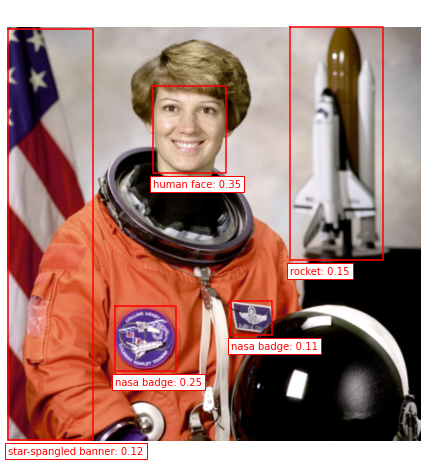

In [ ]:
plot_predictions(
    logits=predictions['pred_logits'], boxes=predictions['pred_boxes'])

# Embed and classify in separate calls
The image embedding, query embedding, and classification steps can be performed separately. This allows pre-computing part of the inference step (e.g. image embedding) and then re-running only the steps for which inputs have changed.



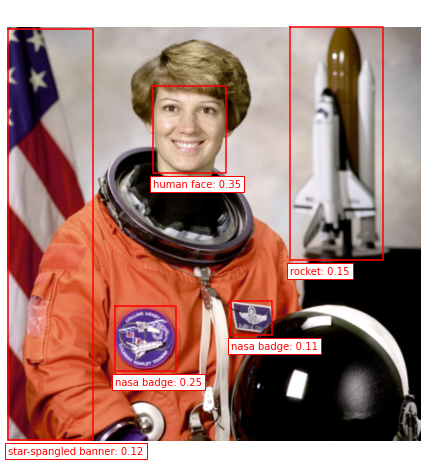

In [ ]:
# Embed image:
feature_map = tf_model({'images': input_image[None, ...]})

# Embed queries:
query_embeddings = tf_model({'tokenized_queries': tokenized_queries[None, ...]})

# Predict boxes:
pred_boxes = tf_model({'feature_map': feature_map})['pred_boxes']

# Classify boxes against queries:
pred_logits = tf_model({
    'feature_map': feature_map,
    'query_embeddings': query_embeddings
})['pred_logits']

plot_predictions(logits=pred_logits[0].numpy(), boxes=pred_boxes[0].numpy())

# Convert to TFLite model

[TensorFlow Lite](https://www.tensorflow.org/lite/guide) is a set of tools that enables on-device machine learning by helping developers run their models on mobile, embedded, and edge devices.

In [ ]:
input_signatures = {
    'end_to_end': {
        'images': tf.TensorSpec(image_shape, tf.float32),
        'tokenized_queries': tf.TensorSpec(query_shape, tf.int64),
    },
    'embed_images': {
        'images': tf.TensorSpec(image_shape, tf.float32),
    },
    'embed_texts': {
        'tokenized_queries': tf.TensorSpec(query_shape, tf.int64),
    },
    'predict_boxes': {
        'feature_map':
            tf.TensorSpec((None, grid_size, grid_size, vision_dim), tf.float32),
    },
    'predict_logits': {
        'feature_map':
            tf.TensorSpec((None, grid_size, grid_size, vision_dim), tf.float32),
        'query_embeddings':
            tf.TensorSpec((None, MAX_NUM_QUERIES, embed_dim), tf.float32),
    },
}


def spec_to_array(spec, batch_size=1):
  shape = spec.shape.as_list()
  shape[0] = batch_size
  return tf.zeros(shape, dtype=spec.dtype).numpy()


tflite_models = {}

for name, signature in input_signatures.items():
  print(f'Converting signature {name!r}...', flush=True)
  inputs = tf.nest.map_structure(spec_to_array, signature)
  serving_func = functools.partial(predict_fn, variables)
  converter = tf.lite.TFLiteConverter.experimental_from_jax(
      [serving_func], [[('input1', inputs)]])
  tflite_models[name] = converter.convert()

print('Done.')

Converting signature 'end_to_end'...
Converting signature 'embed_images'...
Converting signature 'embed_texts'...
Converting signature 'predict_boxes'...
Converting signature 'predict_logits'...
Done.


In [ ]:
# Save the models:
for name, model in tflite_models.items():
  tflite_path = os.path.join(EXPORT_DIR, f'{name}.tflite')
  with tf.io.gfile.GFile(tflite_path, 'wb') as f:
    f.write(model)

In [ ]:
!ls -lh /tmp/exported_model/

total 3.0G
drwxrwsr-x 2 mjlm 53410755 4.0K Jul  6 07:00 assets
-rw-rw-r-- 1 mjlm 53410755 657M Jul  6 07:09 embed_images.tflite
-rw-rw-r-- 1 mjlm 53410755 808M Jul  6 07:09 embed_texts.tflite
-rw-rw-r-- 1 mjlm 53410755 1.5G Jul  6 07:09 end_to_end.tflite
-rw-rw-r-- 1 mjlm 53410755  15M Jul  6 07:09 predict_boxes.tflite
-rw-rw-r-- 1 mjlm 53410755 4.2M Jul  6 07:09 predict_logits.tflite
-rw-rw-r-- 1 mjlm 53410755  60M Jul  6 07:00 saved_model.pb
drwxrwsr-x 2 mjlm 53410755 4.0K Jul  6 07:00 variables


## Test TFLite model

Only the `"end_to_end"` signature is tested here. The other signatures can be called analogously to the TensorFlow code above (see [Embed and classify in separate calls](#scrollTo=Ym1kbeV_904f&line=2&uniqifier=1)).

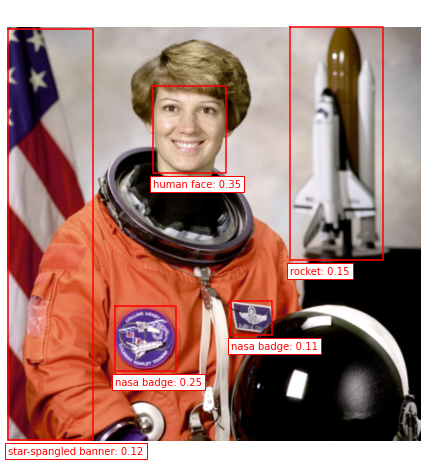

In [ ]:
# Run the model with TensorFlow Lite
interpreter = tf.lite.Interpreter(model_content=tflite_models['end_to_end'])
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
interpreter.set_tensor(input_details[0]["index"], input_image[None, ...])
interpreter.set_tensor(input_details[1]["index"], tokenized_queries[None, ...])

interpreter.invoke()

pred_boxes = interpreter.get_tensor(output_details[2]["index"])
pred_logits = interpreter.get_tensor(output_details[3]["index"])

plot_predictions(logits=pred_logits[0], boxes=pred_boxes[0])